## Generating questions and answers for reaching definitions

In [1]:
import ast
import random

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../output_data/detailed_travel_routes.csv')

df

,id,Domain,Goal,Plan,Detailed Plan
0,0,"[[-121.401001, 38.667599], [-121.2897144693877...","McClellan Airfield (SACRAMENTO, CA) to Hotel S...","[['Drive west.', 'Turn right after 582 meters ...","[[{'instruction': 'Drive west.', 'name': '-', ..."
1,1,"[[-86.44039045, 37.76657014], [-85.64796181454...","BRECKINRIDGE MEMORIAL HOSPITAL (HARDINSBURG, K...","[['Drive south.', 'Turn right after 11 meters ...","[[{'instruction': 'Drive south.', 'name': '-',..."
2,2,"[[-90.07257594727255, 29.95639325], [-90.07819...","Saenger Theatre (New Orleans, LA) to Charity H...","[['Drive southwest on North Rampart Street.', ...",[[{'instruction': 'Drive southwest on North Ra...
3,3,"[[-74.00448291111701, 40.7135665], [-73.496747...","Surrogate's Court (New York, NY) to ST JOHN'S ...","[['Drive northeast on Elk Street.', 'Turn left...",[[{'instruction': 'Drive northeast on Elk Stre...
4,4,"[[-105.1517817, 39.95190922], [-104.8943343, 3...",CENTURA HEALTH-AVISTA ADVENTIST HOSPITAL (LOUI...,"[['Drive southeast.', 'Turn left onto Health P...","[[{'instruction': 'Drive southeast.', 'name': ..."
...,...,...,...,...,...
495,495,"[[-75.598662, 38.370412], [-76.05799123, 38.54...","Gillis-Grier House (Salisbury, MD) to ADVENTIS...","[['Drive southwest on North Division Street.',...",[[{'instruction': 'Drive southwest on North Di...
496,496,"[[-81.04407659335502, 34.00904355], [-81.04072...","Lace House (Columbia, SC) to Building at 1210-...","[['Drive north on Gadsden Street.', 'Turn righ...",[[{'instruction': 'Drive north on Gadsden Stre...
497,497,"[[-78.87293133680211, 42.8848777], [-78.497961...","Hotel Lafayette (Buffalo, NY) to US Post Offic...","[['Drive east on Clinton Street.', 'Turn left ...",[[{'instruction': 'Drive east on Clinton Stree...
498,498,"[[-83.63421550067734, 32.842396353042204], [-8...","Cowles House (Macon, GA) to Emerson-Holmes Bui...","[['Drive southeast on Bond Street.', 'Turn lef...",[[{'instruction': 'Drive southeast on Bond Str...


#### Parsing data into python compatible types

In [2]:
df['Domain'] = df['Domain'].apply(lambda x: ast.literal_eval(x.replace('coordinates = ', '').strip()))

df['Plan'] = df['Plan'].apply(ast.literal_eval)

df['Detailed Plan'] = df['Detailed Plan'].apply(ast.literal_eval)

#### 1. Continuing

Instances where the steps say to continue along a road

##### Finding instances

In [3]:
def find_continuations(df):
    # Define the extra columns:
    columns = list(df.columns) + [
        'continuation_entry',    # Index in the route where we enter the street
        'continuation_exit',     # Index in the route where we exit the street
    ]

    new_df = pd.DataFrame(columns=columns)
    for _, row in df.iterrows():
        for route_idx, detailed_route in enumerate(row['Detailed Plan']):
            current_name = ''
            continuation_entry = 0
            for step_idx, step in enumerate(detailed_route):
                # Skip past all unnamed streets (too vague to ask about continuations)
                if current_name == '':
                    if step['name'] != '-':
                        continuation_entry = step_idx
                        current_name = step['name']
                    else:
                        continue
                
                # Continuing on the same street
                if step['name'] == current_name:
                    continue
                
                # Exiting the current street
                if step['name'] != current_name:
                    # Add this instance if there were multiple steps between this transition
                    if step_idx - continuation_entry > 1:
                        new_row = row.to_dict()
                        new_row.update({
                            'Plan': row['Plan'][route_idx],
                            'Detailed Plan': row['Detailed Plan'][route_idx],  
                            'continuation_entry': continuation_entry,
                            'continuation_exit':  step_idx,
                        })
                        new_df.loc[len(new_df)] = new_row
                    if step['name'] == '-':
                        current_name = ''
                    else:
                        # Update entry idx and current name
                        continuation_entry = step_idx
                        current_name = step['name']

    return new_df


In [4]:
df1 = find_continuations(df)

df1

,id,Domain,Goal,Plan,Detailed Plan,continuation_entry,continuation_exit
0,0,"[[-121.401001, 38.667599], [-121.2897144693877...","McClellan Airfield (SACRAMENTO, CA) to Hotel S...","[Drive west., Turn right after 582 meters or 7...","[{'instruction': 'Drive west.', 'name': '-', '...",9,11
1,0,"[[-121.401001, 38.667599], [-121.2897144693877...","McClellan Airfield (SACRAMENTO, CA) to Hotel S...","[Drive west., Turn right after 582 meters or 7...","[{'instruction': 'Drive west.', 'name': '-', '...",14,16
2,0,"[[-121.401001, 38.667599], [-121.2897144693877...","McClellan Airfield (SACRAMENTO, CA) to Hotel S...","[Drive west., Turn right after 582 meters or 7...","[{'instruction': 'Drive west.', 'name': '-', '...",15,17
3,1,"[[-86.44039045, 37.76657014], [-85.64796181454...","BRECKINRIDGE MEMORIAL HOSPITAL (HARDINSBURG, K...","[Drive south., Turn right after 11 meters or 2...","[{'instruction': 'Drive south.', 'name': '-', ...",7,11
4,1,"[[-86.44039045, 37.76657014], [-85.64796181454...","BRECKINRIDGE MEMORIAL HOSPITAL (HARDINSBURG, K...","[Drive south., Turn right after 11 meters or 2...","[{'instruction': 'Drive south.', 'name': '-', ...",8,10
...,...,...,...,...,...,...,...
1323,499,"[[-86.07399799465895, 33.44498587426914], [-85...","Boxwood (Talladega, AL) to First Presbyterian ...","[Drive east on North Street East/AL 77., Turn ...",[{'instruction': 'Drive east on North Street E...,3,5
1324,499,"[[-86.07399799465895, 33.44498587426914], [-85...","Boxwood (Talladega, AL) to First Presbyterian ...","[Drive east on North Street East/AL 77., Turn ...",[{'instruction': 'Drive east on North Street E...,7,9
1325,499,"[[-86.07399799465895, 33.44498587426914], [-85...","Boxwood (Talladega, AL) to First Presbyterian ...","[Drive east on North Street East/AL 77., Turn ...",[{'instruction': 'Drive east on North Street E...,9,11
1326,499,"[[-86.07399799465895, 33.44498587426914], [-85...","Boxwood (Talladega, AL) to First Presbyterian ...","[Drive east on North Street East/AL 77., Turn ...",[{'instruction': 'Drive east on North Street E...,6,8


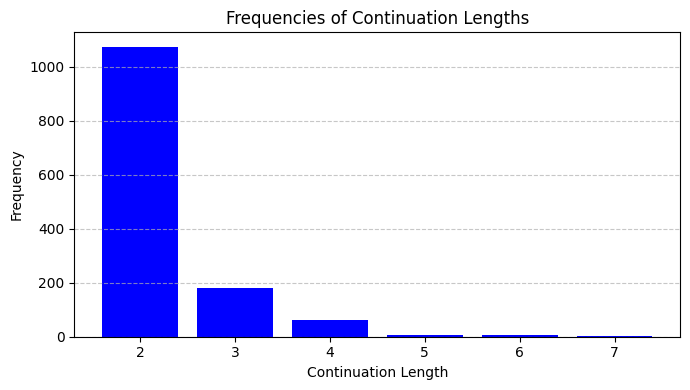

In [5]:
df1['continuation_length'] = df1['continuation_exit'] - df1['continuation_entry']

freqs = df1['continuation_length'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
plt.bar(freqs.index, freqs.values, color='blue')
plt.xlabel('Continuation Length')
plt.ylabel('Frequency')
plt.title('Frequencies of Continuation Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### Filtering

We need to make sure we are not including any data points that contain the same exact segment. To do this, we can extract the subarray that defines each continuation and drop duplicates.

In [6]:
def extract_subarray(row):
    start = row['continuation_entry']
    end = row['continuation_exit']
    return row['Plan'][start:end+1]

df1['subarray'] = df1.apply(extract_subarray, axis=1)

df1 = df1.drop_duplicates(subset='subarray')

print(f'Number of rows with pattern: {df1.shape[0]}')

df1 = df1.drop(columns=['subarray'])

Number of rows with pattern: 830


##### Formatting

We need to determine the steps we will use for the questions.

In [7]:
random.seed(42)

def add_start_and_end(row):
    # Create a range of random values for the two points to be chosen from
    # this is to create points that are similar to the pattern that the model
    # is looking for, but slightly different

    offset = max((row['continuation_exit'] - row['continuation_entry'] + 1) // 2, 4)

    min_idx = max(0, row['continuation_entry'] - offset)
    max_idx = min(len(row['Plan']) - 2, row['continuation_exit'] + offset)

    step_1_idx = random.randint(min_idx, max_idx)
    step_2_idx = random.randint(min_idx, max_idx)

    # If the steps are the same, shift one of them
    if step_1_idx == step_2_idx:
        step_2_idx += 1

    # Return the steps in the correct order
    if step_1_idx < step_2_idx:
        return (step_1_idx, step_2_idx)
    else:
        return (step_2_idx, step_1_idx)


def add_ground_truth(row):
    if row['Detailed Plan'][row['start_idx']]['name'] == '-':
        return "No"
    elif row['Detailed Plan'][row['start_idx']]['name'] == row['Detailed Plan'][row['end_idx']]['name']:
        return "Yes"
    else:
        return "No"

def format_question(row):
    if row['start_idx'] >= row['continuation_entry']:
        street_name = row['Detailed Plan'][row['continuation_entry']]['name']
    else:
        street_name = row['Detailed Plan'][row['start_idx']]['name']
    # Edge case: No name
    if street_name == "-":
        return None
    return f"After Step {row['end_idx']+1}, is the driver still on ‘{street_name}‘ from Step {row['start_idx']+1}?"

df1[['start_idx','end_idx']] = df1.apply(add_start_and_end, axis=1, result_type='expand')

In [8]:
df1['Ground Truth'] = df1.apply(add_ground_truth, axis=1)
df1['Question'] = df1.apply(format_question, axis=1)

percent_none = df1['Question'].isna().mean() * 100
print(f"Percentage of Question = 'None': {percent_none:.2f}%")

df1 = df1[df1['Question'].notna()]

percent_yes = (df1['Ground Truth'] == 'Yes').mean() * 100

print(f"Percentage of 'Yes': {percent_yes:.2f}%")

Percentage of Question = 'None': 8.31%
Percentage of 'Yes': 8.67%


In [9]:
yes_sample = df1[df1['Ground Truth'] == 'Yes'].sample(n=20, random_state=42)
no_sample = df1[df1['Ground Truth'] == 'No'].sample(n=80, random_state=42)

df1 = pd.concat([yes_sample, no_sample])

df1 = df1.filter(items=[
    'id',
    'Goal',
    'Plan',
    'Question',
    'Ground Truth',
])

df1 = df1.sort_values(by=['id'])
percent_yes = (df1['Ground Truth'] == 'Yes').mean() * 100

print(f"Percentage of 'Yes': {percent_yes:.2f}%")

Percentage of 'Yes': 20.00%


In [10]:
df1.to_csv('../output_data/data-flow_analyses/reaching_definitions.csv', index=False)

df1

,id,Goal,Plan,Question,Ground Truth
3,1,"BRECKINRIDGE MEMORIAL HOSPITAL (HARDINSBURG, K...","[Drive south., Turn right after 11 meters or 2...","After Step 8, is the driver still on ‘KY 79‘ f...",No
15,4,CENTURA HEALTH-AVISTA ADVENTIST HOSPITAL (LOUI...,"[Drive southeast., Turn left onto Health Park ...","After Step 12, is the driver still on ‘McCasli...",No
30,12,"St. Ignatius College (Chicago, IL) to Tomek, F...","[Drive east on West Roosevelt Road., Make a le...","After Step 2, is the driver still on ‘West Roo...",Yes
51,20,"ATHOL MEMORIAL HOSPITAL (ATHOL, MA) to LAHEY C...","[Drive southeast., Turn left after 133 meters ...","After Step 7, is the driver still on ‘MA 2‘ fr...",No
82,33,"Oak Ridge Apartments (Evanston, IL) to Loeb, E...","[Drive south on Ridge Avenue., Make a left U-t...","After Step 5, is the driver still on ‘Sheridan...",Yes
...,...,...,...,...,...
1269,476,"Dominguez Ranch Adobe (Compton, CA) to PARKVIE...","[Drive south on South Alameda Street/CA 47., M...","After Step 5, is the driver still on ‘South Al...",Yes
1277,478,CROTCHED MOUNTAIN REHABILITATION CENTER (GREEN...,"[Drive west., Turn left onto Verney Drive., Tu...","After Step 7, is the driver still on ‘Verney D...",No
1291,480,"MONMOUTH MEDICAL CENTER (LONG BRANCH, NJ) to E...","[Drive east., Turn left onto Arthur Avenue., T...","After Step 5, is the driver still on ‘Broadway...",No
1296,485,"PRESENCE SAINT ELIZABETH HOSPITAL (CHICAGO, IL...","[Drive west., Turn left after 33 meters or 11-...","After Step 20, is the driver still on ‘I 294‘ ...",Yes
